In [1]:
import torch
import matplotlib.pyplot as plt
import time

In [2]:
def get_traj_fig(dir_fig=str, fig_name=str):
    # No grid line 
    plt.grid(color = 'grey',alpha=0.1)
    # plt.grid(color = 'grey',alpha=0.0)
    # back ground image
    im = plt.imread("Data/Figures/slit_env.png")
    plt.imshow(im, extent=[-10, 10, -10, 10])
    plt.scatter(0.0,9.0, c = 'springgreen', s=50,marker = 'x')
    xticks = torch.linspace(-10, 10, steps=5)
    yticks = torch.linspace(-10, 10, steps=5)
    plt.xticks(xticks,alpha=1.0)
    plt.yticks(yticks,alpha=1.0)
    plt.savefig(dir_fig + fig_name + '.png')
    # plt.savefig(dir_fig + fig_name + '.pdf')

def get_dpoints_plt(dataset, color="b"):
    """dataset = [N , 2]"""
    X, Y = dataset[:,0], dataset[:,1]
    plt.scatter(X, Y, c=color, s=100, alpha=0.1, marker = 's')

# Load models

In [5]:
env_name = "ObstacleAvoidance/"
model_name = "MHGP-BDI/"
iter = "0/4/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
lnr = torch.load(lnr_path)
lnr["learner"]

## state
relative coordinations
- S: shaft
- G: gripper
- State = [(S-G1)[X,Y,Z], (S-G2)[X,Y,Z]]
    - X: horizontal left-right
    - Y: horizontal up-down
    - Z: vertical up-down

In [10]:
for i in range(6):
    print("{0} D have a range MAX:{1} MIN:{2}".format(i,max(lnr["learner"].X[:,i]),min(lnr["learner"].X[:,i])))

0 D have a range MAX:0.157506063580513 MIN:-0.2952571213245392
1 D have a range MAX:0.013868638314306736 MIN:-0.26684969663619995
2 D have a range MAX:-0.02669530361890793 MIN:-0.29594236612319946
3 D have a range MAX:0.01929630897939205 MIN:-0.4343659579753876
4 D have a range MAX:0.15306416153907776 MIN:-0.12714244425296783
5 D have a range MAX:-0.01952776312828064 MIN:-0.2887387275695801


In [12]:
# Starting point
lnr["learner"].X[1]

tensor([-0.2829, -0.1737, -0.2853, -0.4219, -0.0347, -0.2779])

In [13]:
# End point
lnr["learner"].X[-1]

tensor([ 0.1339, -0.1378, -0.0318, -0.0033,  0.0019, -0.0246])

In [14]:
# coordination of mocap system
# shaft_1_position
# shaft_2_position

In [1]:
from Correct_Trajectories_v1 import CorrectTraj
import torch
from tools import (
    TrajectoryMaker,
    Repository,
)
import time

repo = Repository(dirmake=False)
# env_name = "wideslit-v0"
env_name = "slit-dummy-v0"
env = CorrectTraj(envname="Myenv:" + env_name)
cov = torch.tensor([0.0, 0.0])

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/hanbit-o/.pyenv/versions/3.8.3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'Myenv.slit_dummy_env.SlitDummyEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
class dummyExpert(TrajectoryMaker):
    def __init__(self, goal_flag):
        super().__init__(goal_flag, action_dim=2)

    def action_decision(self, state, goal_flag=False, goal_state=None):
        C_pose = state.squeeze()
        # optimal trajectory making --------------------
        flag = self.goal_flag  # left: -1, right: 1
        sub1 = torch.tensor([2.0 * flag, 2.0])
        sub2 = torch.tensor([5.0 * flag, 1.0])
        sub3 = torch.tensor([8.3 * flag, 0.0])
        sub4 = torch.tensor([8.3 * flag, -1.0])
        sub5 = torch.tensor([8.3 * flag, -3.0])
        goal = torch.tensor([8.3 * flag, -6.0])
        goals = [sub1, sub2, sub3, sub4, sub5, goal]
        # goals = [sub1, sub2, sub3, goal]
        distance = ((C_pose - goals[self.junction]) ** 2).sum()
        # if distance < 0.01:
        if distance < 0.1 and self.junction < len(goals)-1:
            self.junction += 1
        G_pose = goals[self.junction]

        action, self.E, self.int_E = self.PID_controller(
            C_pose,
            G_pose,
            P=1,
            D=0.01,
            I=0.0,
            old_E=self.E,
            old_IE=self.int_E,
        )
        if self.junction == 2:
            # action = action / abs(action)
            # action *= 0.4
            pass
        elif self.junction == 3:
            action = action / abs(action)
            action *= 0.3
        elif self.junction == 4:
            action = action / abs(action)
            action *= 0.2
        elif self.junction == 5:
            action = action / abs(action)
            action *= 0.1

        action = torch.clamp(action, min=-1, max=1).float()
        
        return action.float()

In [3]:
goal = "L"
policy = dummyExpert(goal_flag=goal)

MAX_TRAJ = 1
i = 0
dir_path = "Data/Trajectory/" + repo.d_string + "/"
file_name = "opt_traj_" + env_name + "_" + goal + "_" + str(int(time.time()))
while i < MAX_TRAJ:
    i += 1
    S, A, R, D = env.episode(policy=policy, render=True, cov=cov)
    repo.save_data(
        S,
        dir_path=dir_path,
        file_name=file_name,
    )
    print(S.shape[0])

L_traj_path = dir_path + file_name + ".pickle"

/Users/hanbit-o/code/Visualization_wall_avoidance_results/Myenv/slit_dummy_env.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.state = torch.tensor(init_state)


Data/Trajectory/20211110/opt_traj_slit-dummy-v0_L_1636521513.pickle
353


In [1]:
import argparse
import torch
import framework
from tools import Repository
from BC import BC

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
args = {}
args["title"] = "BC"
args["Max_mixture"] = 1
args["policy_model"] = "IOMHGP"
args["iters"] = 1
args["lengthscale"] = 4.0
args["interval_sampling"] = 15
args["update"] = 1
args["envname"] = "Myenv:slit-dummy-v0"
args["Max_learning_iter"] = 10
args["random_sampling"] = 0
args["supervisor"] = "algorithmic"  # 'human'
# args["exp"] = "cautious_expert"|
# args["exp"] = "over_cautious_expert"
args["exp"] = "dummy_expert"

TRIALS = 1

test = BC(args)

test.repo = Repository()
test.current_trial = 0
test.prologue(params=test.params)
dummy_lnr = test.run_iters()

/Users/hanbit-o/.pyenv/versions/3.8.3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'Myenv.slit_dummy_env.SlitDummyEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/hanbit-o/code/Visualization_wall_avoidance_results/Myenv/slit_dummy_env.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.state = torch.tensor(init_state)


	Iteration: 0
tensor(0.)
iter: 1 reward: tensor([1.])
SUCCESS-------------------
iter: 2 reward: tensor([1.])
SUCCESS-------------------
iter: 3 reward: tensor([1.])
SUCCESS-------------------
iter: 4 reward: tensor([1.])
SUCCESS-------------------
iter: 5 reward: tensor([1.])
SUCCESS-------------------
iter: 6 reward: tensor([1.])
SUCCESS-------------------
iter: 7 reward: tensor([1.])
SUCCESS-------------------
iter: 8 reward: tensor([1.])
SUCCESS-------------------
iter: 9 reward: tensor([1.])
SUCCESS-------------------
iter: 10 reward: tensor([1.])
SUCCESS-------------------
Demo results: 10.0 S | 0.0 F
mean 100.0% | std 0.0%
Data/20211110/17/BC/0/0/demo.pickle
++++++++++++++0 th iter demo saved ++++++++++++++
E step
M step
--------------------
fkern 1  :  tensor([4.0197])
gkern :  tensor([4.0465])
mu0 :  tensor([0.0098, 0.0098])
v_beta_0 :  tensor(102.5553)
1  th Marginalized VB :  tensor(87.9799, grad_fn=<NegBackward>)
Z :  tensor([25.])
E step
M step


/Users/hanbit-o/code/Visualization_wall_avoidance_results/Correct_Trajectories_v1.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  while torch.tensor(R).sum() < Max_traj:


--------------------
fkern 1  :  tensor([4.1232])
gkern :  tensor([4.1598])
mu0 :  tensor([0.0095, 0.0095])
v_beta_0 :  tensor(105.1759)
2  th Marginalized VB :  tensor(85.5298, grad_fn=<NegBackward>)
Z :  tensor([25.])
E step
M step
--------------------
fkern 1  :  tensor([4.2292])
gkern :  tensor([4.2722])
mu0 :  tensor([0.0093, 0.0093])
v_beta_0 :  tensor(107.8634)
3  th Marginalized VB :  tensor(83.2077, grad_fn=<NegBackward>)
Z :  tensor([25.])
E step
M step
--------------------
fkern 1  :  tensor([4.3379])
gkern :  tensor([4.3856])
mu0 :  tensor([0.0091, 0.0091])
v_beta_0 :  tensor(110.6196)
4  th Marginalized VB :  tensor(81.0085, grad_fn=<NegBackward>)
Z :  tensor([25.])
E step
M step
--------------------
fkern 1  :  tensor([4.4494])
gkern :  tensor([4.5009])
mu0 :  tensor([0.0088, 0.0088])
v_beta_0 :  tensor(113.4462)
5  th Marginalized VB :  tensor(78.9279, grad_fn=<NegBackward>)
Z :  tensor([25.])
E step
M step
--------------------
fkern 1  :  tensor([4.5636])
gkern :  tenso

In [54]:
import torch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

In [88]:
X_range = [-15.5, -1]
Y_range = [-11, 9]
def get_traj_fig(dir_fig=str, fig_name=str):
    # No grid line 
    plt.grid(color = 'grey',alpha=0.1)
    # plt.grid(color = 'grey',alpha=0.0)
    # back ground image
    im = plt.imread("Data/Figures/obstacle_avoidance_env.png")
    plt.imshow(im, extent=[X_range[0],X_range[1], Y_range[0],Y_range[1]],alpha=1.0)
    # imagebox = OffsetImage(im, zoom=1, zorder=1)
    # ab = AnnotationBbox(imagebox, (0, 0), frameon=False)
    # fig, ax = plt.subplots()
    # cbar_ax = fig.add_axes([0.7, .42, 0.1, 0.1])
    # cbar_ax.add_artist(ab)
    # cbar_ax.axis('off')

    xticks = torch.linspace(int(X_range[0]),int(X_range[1]), steps=5)
    yticks = torch.linspace(int(Y_range[0]),int(Y_range[1]), steps=5)

    plt.xticks(xticks,alpha=1.0)
    plt.yticks(yticks,alpha=1.0)
    plt.xlabel("X",fontsize=15,labelpad=1)
    plt.ylabel("Z",fontsize=15, labelpad=-7.0)
    plt.savefig(dir_fig + fig_name + '.png',transparent=True)
    # plt.savefig(dir_fig + fig_name + '.pdf')

def get_dpoints_plt(dataset, color="b"):
    """dataset = [N , 2]"""
    # X, Y = dataset[:,0], dataset[:,1]
    X, Y = dataset[:,0][::3], dataset[:,1][::3]
    plt.scatter(X, Y, c=color, s=100, alpha=0.1, marker = 's')

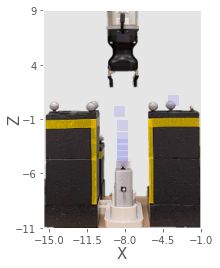

In [89]:
get_dpoints_plt(dummy_lnr.X)
get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Data_points_map/", fig_name='dummy_exp_'+ str(int(time.time())) )

## Heat-map of disturbance level

In [90]:
import numpy as np
# make these smaller to increase the resolution
# dX, dY = 0.25, 0.25
dX, dY = 0.2, 0.2
# dX, dY = 0.15, 0.15
# dX, dY = 1.0, 1.0

# generate 2 2d grids for the x & y bounds
Y, X = np.mgrid[slice(Y_range[0],Y_range[1] + dY, dY),
                slice(X_range[0],X_range[1] + dX, dX)]


# X,Y = np.mgrid[-10:10:0.5, -10:10:0.5]
states = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T)
_,_, disturbance = dummy_lnr.predict(states)
D = (disturbance**2).sum(1).sqrt()

(101, 74)


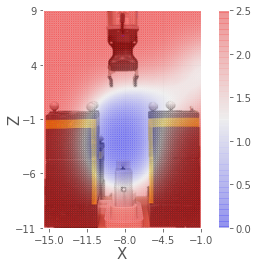

In [86]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
z_min, z_max = z.min(), z.max()

# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=0.0, vmax=1.5, alpha=0.6)
c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.0, vmax=2.5, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.0, vmax=2.5, alpha=0.5)
# c = plt.pcolormesh(x, y, z, cmap='Reds', vmin=0.0, vmax=1.5, alpha=0.6)

plt.colorbar(c)

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/", fig_name='state_dependent'+ str(int(time.time())) )

(101, 74)


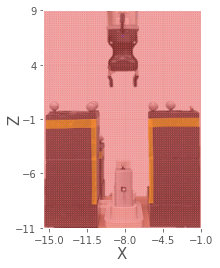

In [87]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
z = z/abs(z)
z *= 2.0
z_min, z_max = z.min(), z.max()

# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=0.0, vmax=1.5, alpha=0.6)
c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.0, vmax=2.5, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='Reds', vmin=0.0, vmax=1.5, alpha=0.6)

# plt.colorbar(c)

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/", fig_name='state_independent'+ str(int(time.time())) )